
🧪 進行多重非監督特徵工程...
🛡️ 生成Isolation Forest特徵...
🔍 使用KMeans建立群集特徵...
🛡️ 使用One-Class SVM產生異常分數...
🌲 使用隨機森林產生異常分數...

🎯 訓練XGBoost（scale_pos_weight = 578.55）...

📊 XGBoost模型（默認門檻0.5） 評估結果
Accuracy   : 0.9994733330992591
Precision  : 0.9724770642201835
Recall     : 0.7162162162162162
F1 Score   : 0.8249027237354085

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.72      0.82       148

    accuracy                           1.00     85443
   macro avg       0.99      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443



<Figure size 600x500 with 0 Axes>

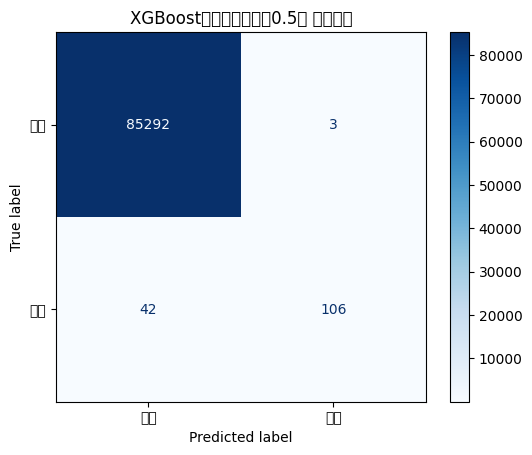


📊 XGBoost模型（最佳門檻0.0001） 評估結果
Accuracy   : 0.9995318516437859
Precision  : 0.95
Recall     : 0.7702702702702703
F1 Score   : 0.8507462686567164

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.77      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



<Figure size 600x500 with 0 Axes>

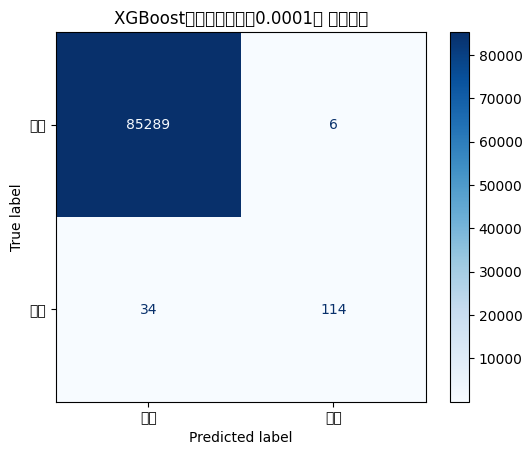


🔍 高精度模式（Precision ≥ 95%）：門檻 = 0.0001

📊 高精度模式 評估結果
Accuracy   : 0.9995318516437859
Precision  : 0.95
Recall     : 0.7702702702702703
F1 Score   : 0.8507462686567164

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.77      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



<Figure size 600x500 with 0 Axes>

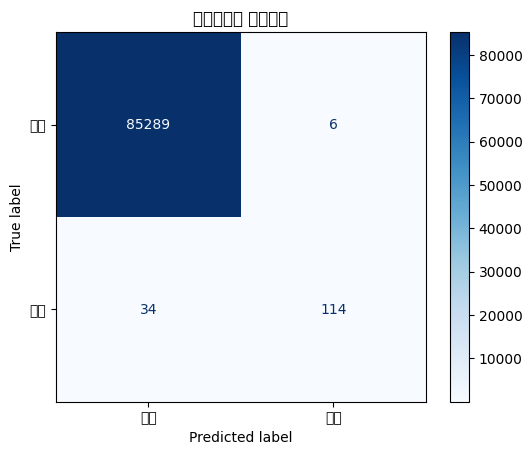


✅ 模型訓練與評估完成！


In [15]:
# ex2.ipynb - 信用卡詐欺檢測（修正版）
# Author: [請寫上你的名字或學號]

# ====== 🔹 套件匯入區 ======
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# ====== 🔹 資料載入與前處理 ======
try:
    import kagglehub
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    data = pd.read_csv(f"{path}/creditcard.csv")
except:
    print("使用本地資料路徑")
    data = pd.read_csv("creditcard.csv")

# 處理欄位與標準化
data['Class'] = data['Class'].astype(int)
data = data.drop(['Time'], axis=1)

# 使用RobustScaler對Amount進行標準化
scaler = RobustScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# ====== 🔹 特徵切分（先分割再生成特徵） ======
X = data.drop(columns=['Class'])
y = data['Class'].values

# 先分割數據集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ====== 🔹 多重非監督特徵工程（修正後） ======
print("\n🧪 進行多重非監督特徵工程...")

# 標準化特徵用於聚類
scaler_cluster = StandardScaler()
X_train_scaled = scaler_cluster.fit_transform(X_train)
X_test_scaled = scaler_cluster.transform(X_test)

# 1. Isolation Forest 特徵（僅在訓練集上擬合）
print("🛡️ 生成Isolation Forest特徵...")
iso_model = IsolationForest(n_estimators=150, contamination=0.0017, random_state=42)
iso_model.fit(X_train_scaled[y_train == 0])  # 僅使用正常樣本訓練

# 為訓練集和測試集生成特徵
X_train['IsoOutlier'] = (iso_model.predict(X_train_scaled) == -1).astype(int)
X_train['AnomalyScore'] = -iso_model.decision_function(X_train_scaled)
X_test['IsoOutlier'] = (iso_model.predict(X_test_scaled) == -1).astype(int)
X_test['AnomalyScore'] = -iso_model.decision_function(X_test_scaled)

# 2. KMeans 群集特徵
print("🔍 使用KMeans建立群集特徵...")
kmeans_model = KMeans(n_clusters=5, random_state=42)
kmeans_model.fit(X_train_scaled[y_train == 0])  # 僅使用正常樣本訓練

X_train['KMeansCluster'] = kmeans_model.predict(X_train_scaled)
X_test['KMeansCluster'] = kmeans_model.predict(X_test_scaled)

# 3. One-Class SVM 異常分數（修正後的版本）
print("🛡️ 使用One-Class SVM產生異常分數...")
ocsvm = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale')
ocsvm.fit(X_train_scaled[y_train == 0])  # 僅使用正常樣本訓練

X_train['OCSVM_Score'] = -ocsvm.decision_function(X_train_scaled)
X_test['OCSVM_Score'] = -ocsvm.decision_function(X_test_scaled)

# 4. 隨機森林異常分數
print("🌲 使用隨機森林產生異常分數...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

X_train['RF_Anomaly'] = rf.predict_proba(X_train)[:, 1]
X_test['RF_Anomaly'] = rf.predict_proba(X_test)[:, 1]

# ====== 🔹 訓練XGBoost分類器 ======
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n🎯 訓練XGBoost（scale_pos_weight = {pos_weight:.2f}）...")

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# ====== 🔹 模型評估 ======
def enhanced_evaluation(y_true, y_pred, y_prob=None, model_name="模型"):
    print(f"\n📊 {model_name} 評估結果")
    print("="*50)
    print("Accuracy   :", accuracy_score(y_true, y_pred))
    print("Precision  :", precision_score(y_true, y_pred))
    print("Recall     :", recall_score(y_true, y_pred))
    print("F1 Score   :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # 繪製混淆矩陣
    plt.figure(figsize=(6,5))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                          display_labels=['正常', '詐欺'],
                                          cmap='Blues')
    plt.title(f'{model_name} 混淆矩陣')
    plt.show()

# 預測測試集
y_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)  # 默認0.5門檻

enhanced_evaluation(y_test, y_pred, y_prob, "XGBoost模型（默認門檻0.5）")

# ====== 🔹 門檻優化 ======
from sklearn.metrics import precision_recall_curve

# 計算PR曲線
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# 找出最佳F1分數的門檻值
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
y_pred_best = (y_prob >= best_thresh).astype(int)

enhanced_evaluation(y_test, y_pred_best, y_prob, f"XGBoost模型（最佳門檻{best_thresh:.4f}）")

# ====== 🔹 高精度模式 ======
# 找出Precision >= 0.95的最小門檻
high_prec_idx = np.where(precision >= 0.95)[0][0]
high_prec_thresh = thresholds[high_prec_idx]
y_pred_high_prec = (y_prob >= high_prec_thresh).astype(int)

print(f"\n🔍 高精度模式（Precision ≥ 95%）：門檻 = {high_prec_thresh:.4f}")
enhanced_evaluation(y_test, y_pred_high_prec, y_prob, "高精度模式")

print("\n✅ 模型訓練與評估完成！")